In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils.conn_data import load_pickle
from portfolio_tools.Diagnostics import Diagnostics
from functionals.Functionals import Functionals


plt.style.use('ggplot')

In [2]:
# parameters
k = 1000
train = True
strategy_name = "etfstsm_moskowitz"
diag = Diagnostics()

strategy_name = f"training_{strategy_name}" if train else strategy_name

# paths
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
dirs = sorted(os.listdir(os.path.join(outputs_path, strategy_name)))

print(dirs)

['% Positive Ret._means_0.1_1000', '% Positive Ret._means_0.2_1000', '% Positive Ret._means_0.3_1000', '% Positive Ret._means_0.4_1000', '% Positive Ret._means_0.5_1000', '% Positive Ret._means_0.6_1000', '% Positive Ret._means_0.7_1000', '% Positive Ret._means_0.8_1000', '% Positive Ret._means_0.9_1000', '% Positive Ret._means_1.0_1000', 'AvgDD_means_0.1_1000', 'AvgDD_means_0.2_1000', 'AvgDD_means_0.3_1000', 'AvgDD_means_0.4_1000', 'AvgDD_means_0.5_1000', 'AvgDD_means_0.6_1000', 'AvgDD_means_0.7_1000', 'AvgDD_means_0.8_1000', 'AvgDD_means_0.9_1000', 'AvgDD_means_1.0_1000', 'MaxDD_means_0.1_1000', 'MaxDD_means_0.2_1000', 'MaxDD_means_0.3_1000', 'MaxDD_means_0.4_1000', 'MaxDD_means_0.5_1000', 'MaxDD_means_0.6_1000', 'MaxDD_means_0.7_1000', 'MaxDD_means_0.8_1000', 'MaxDD_means_0.9_1000', 'MaxDD_means_1.0_1000', 'Sharpe_means_0.1_1000', 'Sharpe_means_0.2_1000', 'Sharpe_means_0.3_1000', 'Sharpe_means_0.4_1000', 'Sharpe_means_0.5_1000', 'Sharpe_means_0.6_1000', 'Sharpe_means_0.7_1000', 'Sha

Utility: MaxDD, Functional: means, Alpha: 0.1, Bsize: 1000


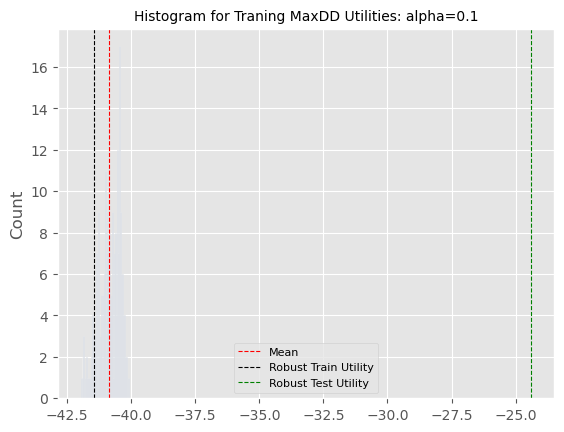

Utility: MaxDD, Functional: means, Alpha: 0.2, Bsize: 1000


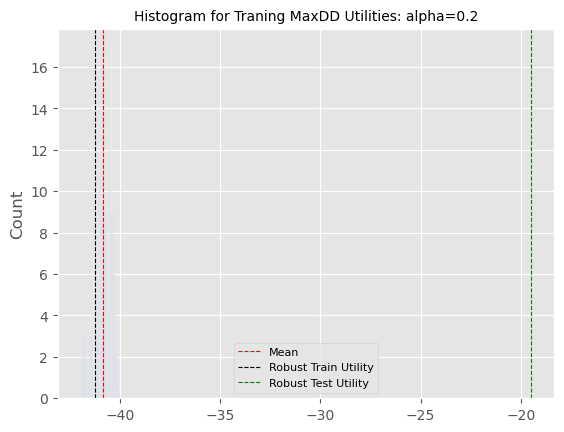

Utility: MaxDD, Functional: means, Alpha: 0.3, Bsize: 1000


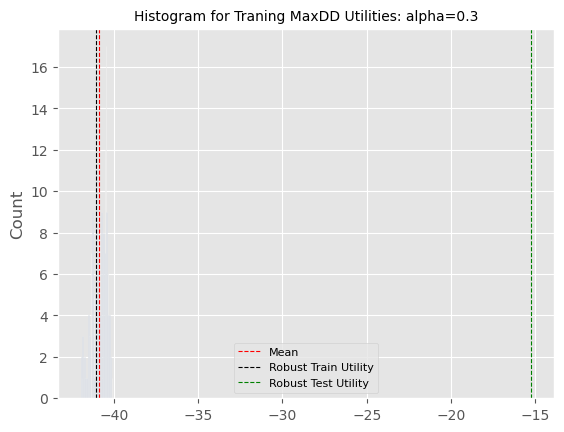

Utility: MaxDD, Functional: means, Alpha: 0.4, Bsize: 1000


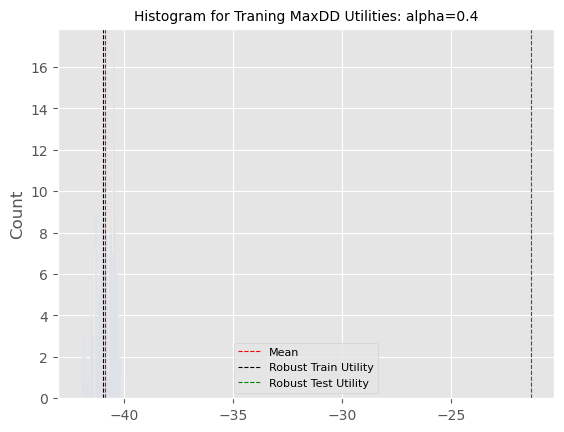

Utility: MaxDD, Functional: means, Alpha: 0.5, Bsize: 1000


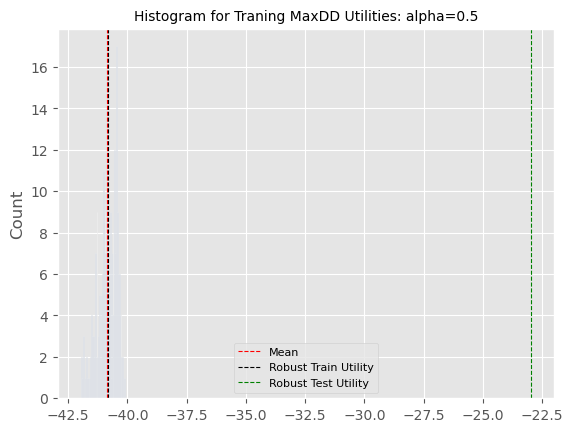

Utility: MaxDD, Functional: means, Alpha: 0.6, Bsize: 1000


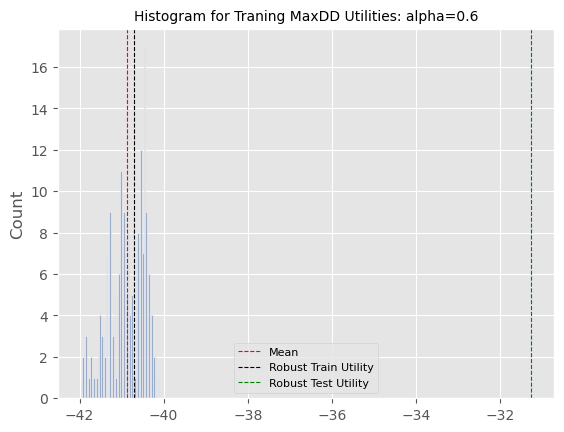

Utility: MaxDD, Functional: means, Alpha: 0.7, Bsize: 1000


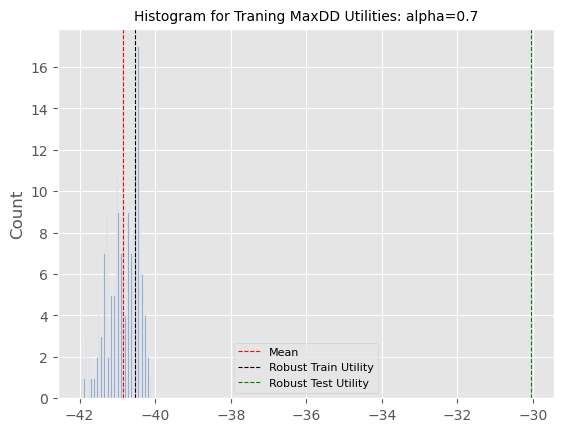

Utility: MaxDD, Functional: means, Alpha: 0.8, Bsize: 1000


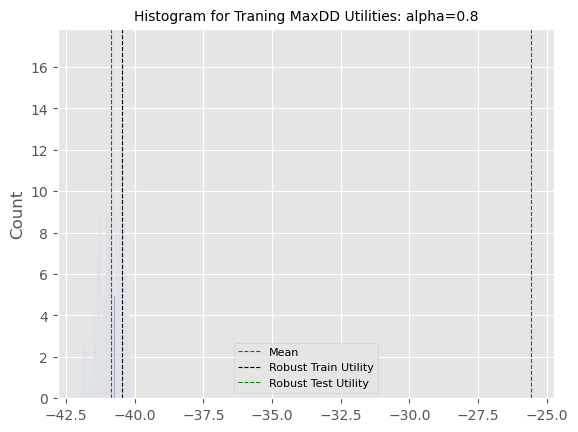

Utility: MaxDD, Functional: means, Alpha: 0.9, Bsize: 1000


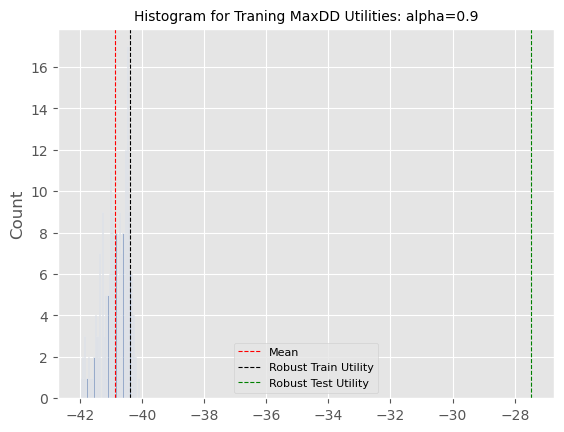

Utility: MaxDD, Functional: means, Alpha: 1.0, Bsize: 1000


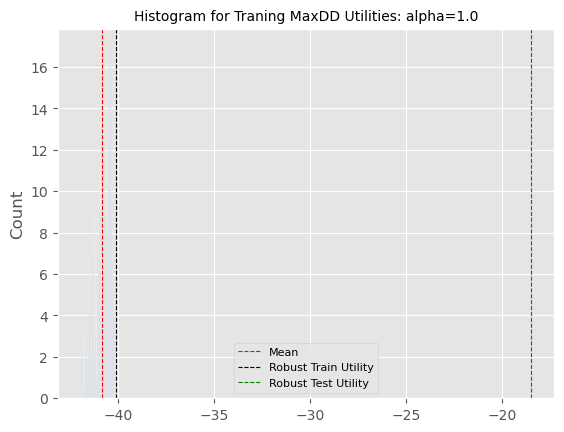

In [8]:
windows = range(30, 252 + 1, 1)

all_results = []
for dir in dirs:

    if k != int(dir.split("_")[-1]):
        continue

    utility = dir.split("_")[0]

    if utility != "MaxDD":
        continue

    functional = dir.split("_")[1]
    alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
    Bsize = dir.split("_")[3]

    functionals = Functionals(alpha=float(alpha))

    print(f"Utility: {utility}, Functional: {functional}, Alpha: {alpha}, Bsize: {Bsize}")

    # # list files in directory
    # os.listdir(os.path.join(outputs_path, strategy_name, dir))

    optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
    portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
    portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

    # apply functional to vector of utility vectors
    utilities_val_train = functionals.means(x=optmization_train["utilities"])

    # get the chosen utility vector
    chosen_utility_vector_train = functionals.apply_functional(x=optmization_train["utilities"], func=functional)

    # compute robust utility
    robust_utility_train = chosen_utility_vector_train.mean()

    # find position of scores that match final_utility
    position = functionals.find_utility_position(utilities=optmization_train["utilities"], utility_value=chosen_utility_vector_train)

    # find window that matches position
    robust_parameter = windows[position]

    # portfolio results
    robust_utility_test = diag.compute_metric(portoflio_returns=portfolio_test['agg_scaled_portfolio_returns'], metric_name=utility)

    # save results
    round_digits = 2 if utility != '% Positive Ret.' else 4
    results = {
        "Utility": utility,
        "Functional": functional,
        "Alpha": alpha,
        "Bsize": Bsize,
        "Robust Parameter": robust_parameter,
        "Train Utility Mean": np.round(utilities_val_train.mean().item(), round_digits),
        "Train Utility Std": np.round(utilities_val_train.std().item(), round_digits),
        "Robust Train Utility": np.round(robust_utility_train.mean().item(), round_digits),
        "Robust Test Utility": np.round(robust_utility_test, round_digits),
        "Generalization Gap": np.round(robust_utility_test - robust_utility_train, round_digits).item(),
    }

    results_df = pd.DataFrame([results])
    all_results.append(results_df)

    # plot
    utility_val_df = pd.DataFrame(utilities_val_train, columns=[utility])
    ax = sns.histplot(data=utility_val_df, palette="deep", bins=50)

    plt.axvline(x=utilities_val_train.mean().item(), color='red', linestyle='--', label='Mean', linewidth=0.8)
    plt.axvline(x=robust_utility_train, color='black', linestyle='--', label='Robust Train Utility', linewidth=0.8)
    plt.axvline(x=robust_utility_test, color='green', linestyle='--', label='Robust Test Utility', linewidth=0.8)
    plt.legend(fontsize=8)
    plt.title(f"Histogram for Traning {dir.split('_')[0]} Utilities: alpha={alpha}", size=10)

    plt.show()
all_results_df = pd.concat(all_results)
all_results_df["Alpha"] = ["max" if val == "1.0" else val for val in all_results_df["Alpha"]]

In [4]:
all_results_df

,Utility,Functional,Alpha,Bsize,Robust Parameter,Train Utility Mean,Train Utility Std,Robust Train Utility,Robust Test Utility,Generalization Gap
0,% Positive Ret.,means,0.1,1000,52,0.5002,0.0018,0.4980,0.5081,0.010100
0,% Positive Ret.,means,0.2,1000,73,0.5002,0.0018,0.4988,0.5253,0.026600
0,% Positive Ret.,means,0.3,1000,95,0.5002,0.0018,0.4992,0.5242,0.025000
0,% Positive Ret.,means,0.4,1000,127,0.5002,0.0018,0.4998,0.5300,0.030100
0,% Positive Ret.,means,0.5,1000,144,0.5002,0.0018,0.5001,0.5242,0.024100
0,% Positive Ret.,means,0.6,1000,164,0.5002,0.0018,0.5007,0.5334,0.032700
0,% Positive Ret.,means,0.7,1000,186,0.5002,0.0018,0.5015,0.5230,0.021600
0,% Positive Ret.,means,0.8,1000,207,0.5002,0.0018,0.5019,0.5219,0.019900
0,% Positive Ret.,means,0.9,1000,231,0.5002,0.0018,0.5025,0.5253,0.022800
0,% Positive Ret.,means,max,1000,248,0.5002,0.0018,0.5030,0.5276,0.024700


In [5]:
df_filtered = all_results_df.copy()
df_filtered.loc[df_filtered['Alpha'] == 'max', 'Alpha'] = 1.0
df_filtered['Alpha'] = pd.to_numeric(df_filtered['Alpha'])
df_filtered["Generalization Gap Abs"] = df_filtered["Generalization Gap"].abs()

utilities = df_filtered['Utility'].unique()

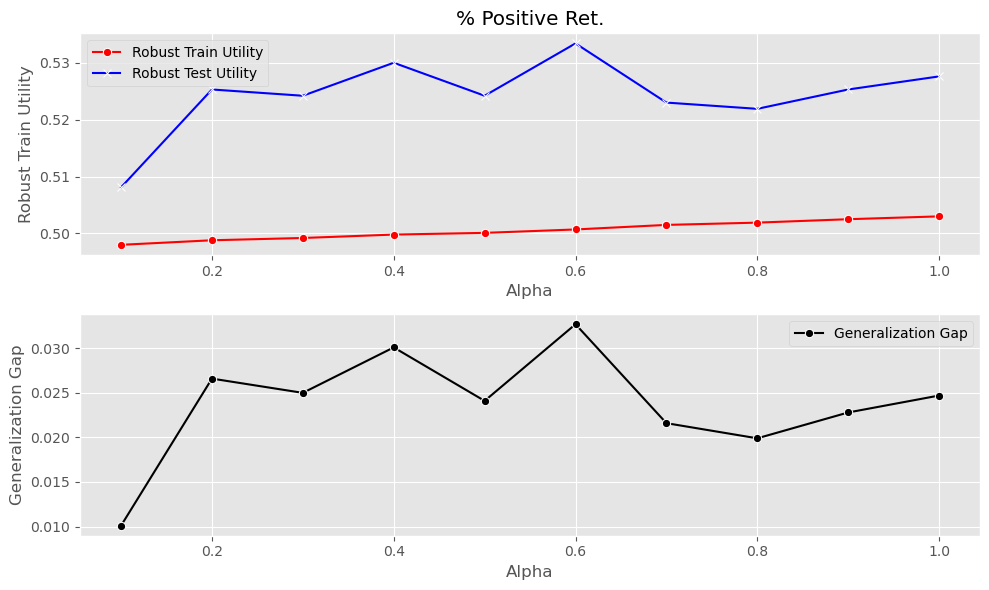

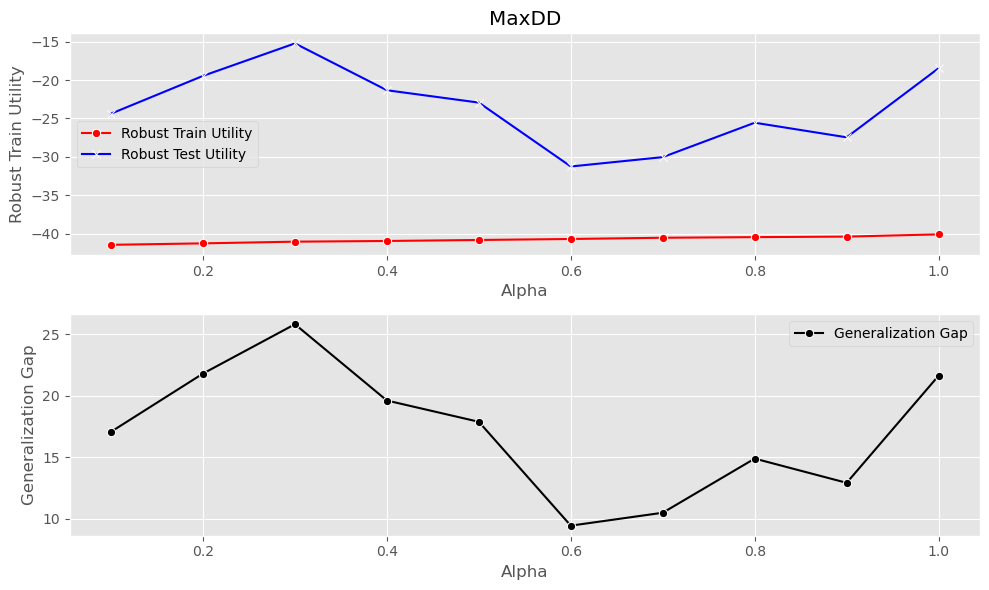

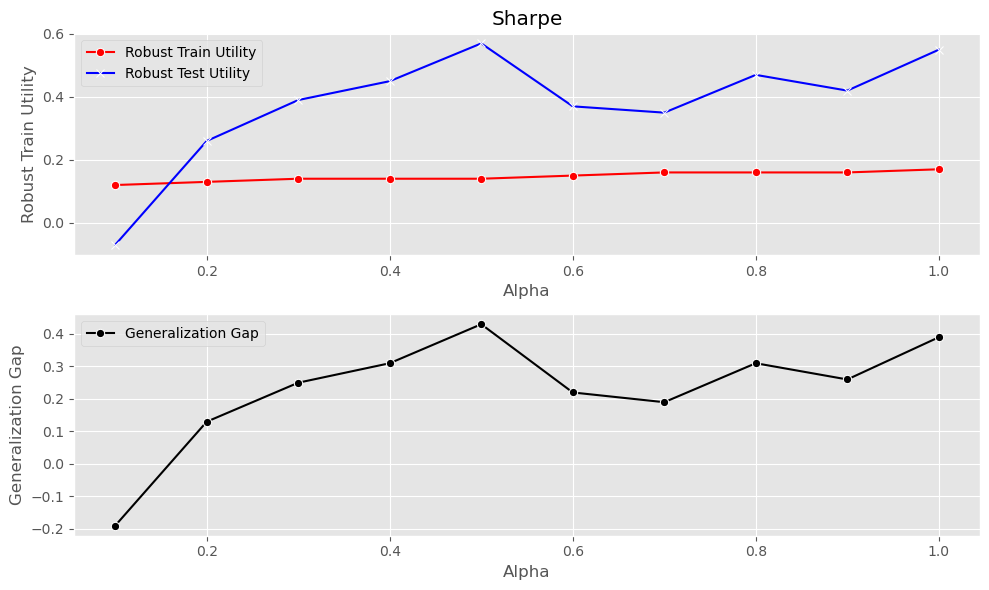

In [7]:
# Iterate over utilities and plot on a separate subplot
for i, utility in enumerate(utilities):

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
    axes = axes.flatten()   
    
    # Plot Generalization Gap Abs
    sns.lineplot(
        data=df_filtered[df_filtered['Utility'] == utility],
        x='Alpha', y='Robust Train Utility',
        ax=axes[0], marker='o', label='Robust Train Utility', color='r'
    )
    # Plot Train Utility Std on the same axis
    sns.lineplot(
        data=df_filtered[df_filtered['Utility'] == utility],
        x='Alpha', y='Robust Test Utility',
        ax=axes[0], marker='x', label='Robust Test Utility', color='b'
    )
    axes[0].set_title(f'{utility}')
    axes[0].set_xlabel('Alpha')
    axes[0].legend()  # This adds a legend to distinguish between the plots

    sns.lineplot(
        data=df_filtered[df_filtered['Utility'] == utility],
        x='Alpha', y='Generalization Gap',
        ax=axes[1], marker='o', label='Generalization Gap', color='black'
    )

    axes[1].set_xlabel('Alpha')

    # Adjust layout for better fit
    plt.tight_layout()
    plt.show()

In [ ]:
# # Setup the matplotlib figure and axes
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# axes = axes.flatten()

# # Iterate over utilities and plot on a separate subplot
# for i, utility in enumerate(utilities):
#     sns.lineplot(
#         data=df_filtered[df_filtered['Utility'] == utility],
#         x='Alpha', y='Generalization Gap Abs',
#         ax=axes[i], marker='o'
#     )

#     axes[i].set_title(f'{utility}')
#     axes[i].set_xlabel('Alpha')
#     axes[i].set_ylabel('Generalization Gap Abs')

# # Adjust layout for better fit
# plt.tight_layout()
# plt.show()